In [3]:
import os
import toml
from tqdm import tqdm
from prettytable import PrettyTable

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from l5kit.geometry import transform_points
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer

# Define paths for project folder and for data folder:

In [4]:
PROJECT_PATH = 'PATH_TO_PROJECT'
PATH_TO_DATA = 'PATH_TO_DATA'

os.chdir(PROJECT_PATH)
os.environ["L5KIT_DATA_FOLDER"] = PATH_TO_DATA

In [86]:
# Load config 
cfg = toml.load('config.toml')
cfg['raster_params']['map_type'] = 'py_satellite'

# Load data

In [87]:
MODE = cfg['mode']

dm = LocalDataManager(None)
rasterizer = build_rasterizer(cfg, dm)

if MODE == 'train_sample':
  train_cfg = cfg['sample_data_loader']
if MODE == 'train_full':
  train_cfg = cfg['train_data_loader']
  
print(f'Current mode: {MODE}.')

Current mode: train_sample.


In [88]:
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer, min_frame_future=cfg['min_frame_future'])
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg['shuffle'],
                              batch_size=train_cfg['batch_size'],
                              num_workers=train_cfg['num_workers'])
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: you're running with custom min_frame_future of 50
  


# Visualisation of CVAE samples
Samples of trajectories generated from CVAE distribution P(z | frame and history representation), z - sample fom standard normal distribution.

In [8]:
from lyft_motion_prediction.utils.load_models import *
from lyft_motion_prediction.utils.plot_utils import plot_cvae_predictions
from lyft_motion_prediction.train.train_utils import sample_trajectories_batch

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load pretrained model
cvae_model = get_model('CVAE', cfg, device)

In [104]:
# Data sample
data_batch = next(iter(train_dataloader))
context = data_batch['image'].to(device)

In [105]:
trajectories_batch = sample_trajectories_batch(cvae_model, context, device, cfg)

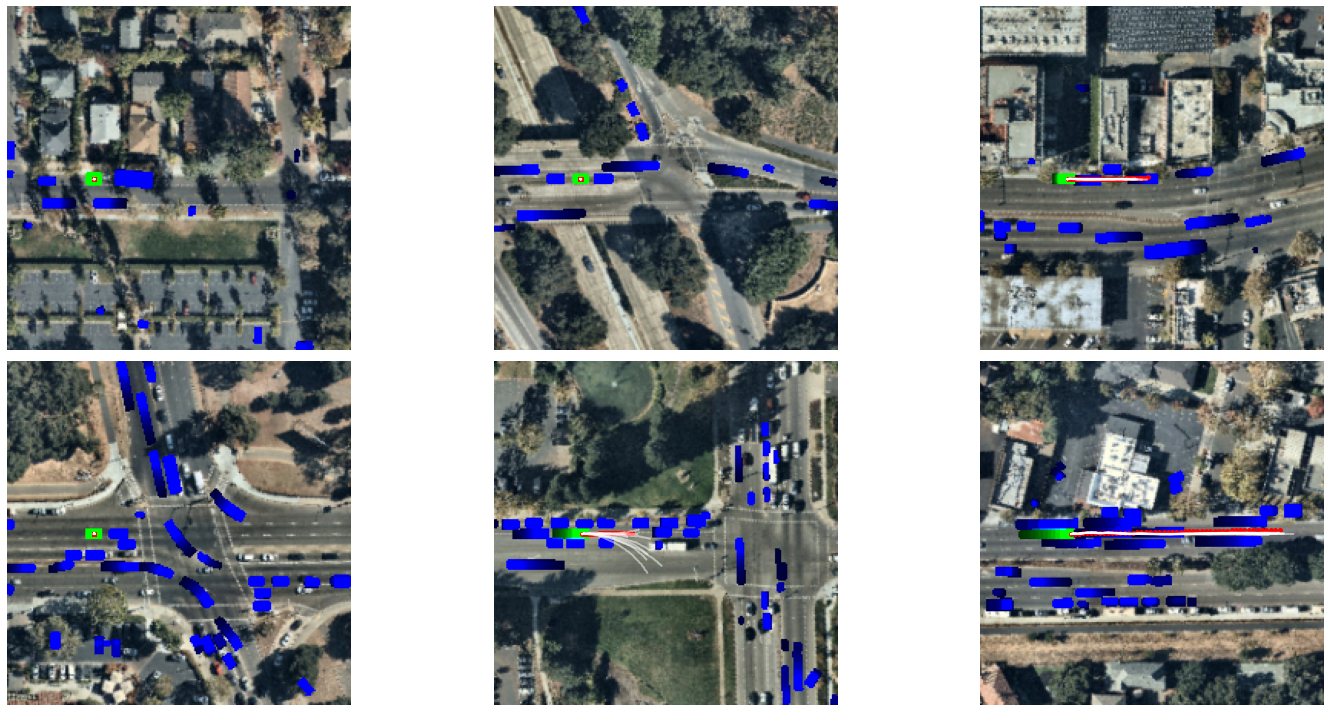

In [109]:
plot_cvae_predictions(data_batch,
                      train_dataset,
                      trajectories_batch,
                      transform_points)

# Visualisation of agents motion prediction
3 trajectories with probabilities [0.7, 0.2, 0.1] extracted from CVAE distribution. Red trajectory is a ground truth.

In [17]:
from lyft_motion_prediction.models import TrajectoriesPredictor

In [18]:
# Load pretrained models
cvae_model = get_model('CVAE', cfg, device)
extractor_model = get_model('Extractor', cfg, device)

# Initialize complet model
model = TrajectoriesPredictor(cvae_model, extractor_model, cfg, device)

In [110]:
# Data sample
data_batch = next(iter(train_dataloader))

In [111]:
# Predict trajectories given frame
predicitons = model(data_batch)

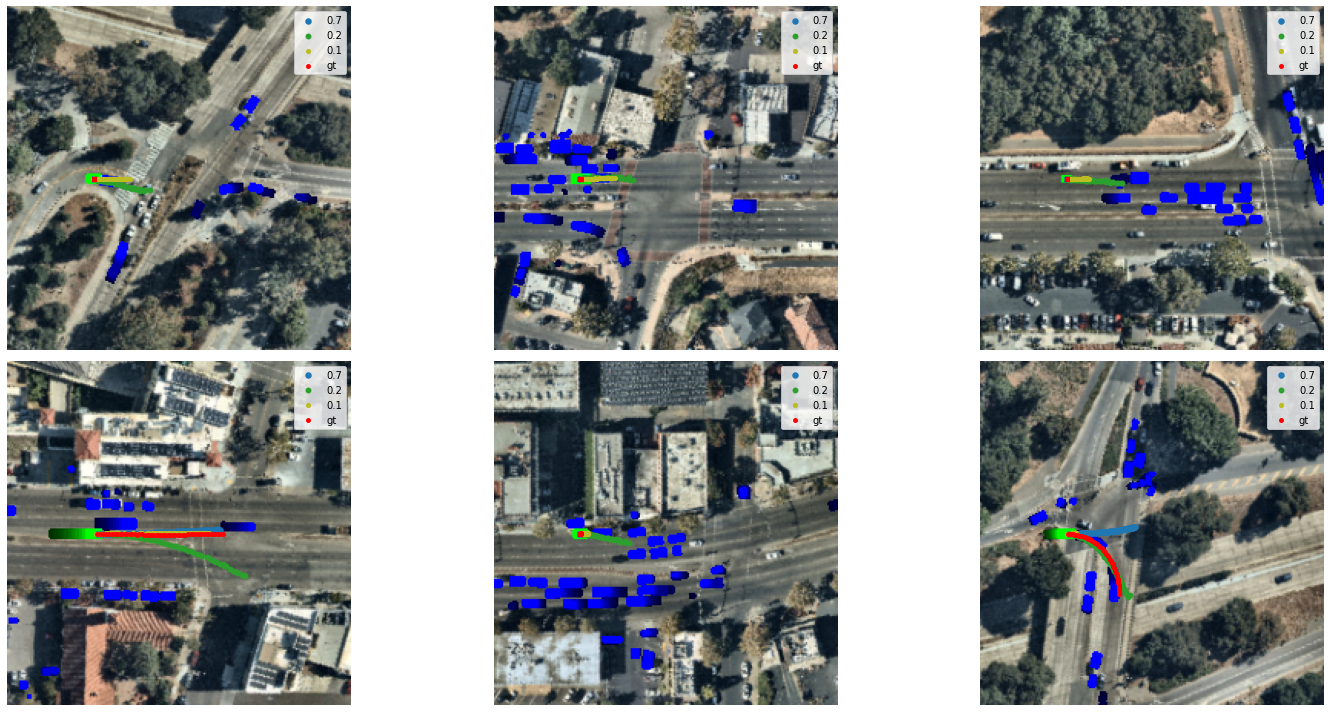

In [112]:
plot_extr_predictions(data_batch,
                      train_dataset,
                      predicitons,
                      transform_points,
                      zoom=False)